In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import shapefile
import geopy
import geocoder
import reverse_geocoder as rg
from pygeocoder import Geocoder
import shapely
import pylab
import scipy.stats as stats
%matplotlib inline

In [55]:
#Load the dataframe
df = pd.read_excel('/Users/TCummings03/Desktop/Rent_Hop_DC2.xlsx')

In [56]:
df.head()

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,Park-like setting,Military housing,Smoke Free Community,Eat-In Kitchens,Pet rent of $50,Lovely Rock Creek Park Views,24-Hour Front Desk Attendant,Vaulted Ceilings,Generous closets space,Handrails
0,https://www.renthop.com/apartments/2400-pennsy...,2400 Pennsylvania Ave Nw,38.9029,-77.0518,17137566,NaN,1630,0.5,1.0,[],...,0,0,0,0,0,0,0,0,0,0
1,https://www.renthop.com/apartments/4905-southl...,4905 Southland Ave,38.8180,-77.1479,2007984,1160.0,1975,3.0,2.0,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,0
2,https://www.renthop.com/apartments/9704-clark-...,9704 Clark Pl,38.7434,-77.4669,2059874,515.0,1102,1.0,1.5,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,0
3,https://www.renthop.com/apartments/1002-kenneb...,1002 Kennebec Street,38.8194,-76.9922,3427733,989.0,1529,3.0,2.5,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,0
4,https://www.renthop.com/apartments/5601-regenc...,5601 Regency Park Court,38.8387,-76.9098,2096152,989.0,1299,2.0,1.5,"['Featured', 'Air conditioning', 'Business cen...",...,0,0,0,0,0,0,0,0,0,0


In [57]:
#Explore the amenities
df1 = df.copy()

dfamenities = df1.iloc[:,10:1427]

In [58]:
#drop columns without any amenities, so they don't add noise to model
dropthese = df1[df1['amenities'] == '[]'].index

df1 = df1.drop(dropthese)

In [59]:
#It looks like there are duplicate amenities
np.mean(dfamenities).nlargest(10)

Central A/C         0.356022
dishwasher          0.320113
Dishwasher          0.315763
refrigerator        0.312863
Exterior Brick      0.273371
Refrigerator        0.272091
Garbage Disposer    0.261344
Forced Air          0.258871
Dryer               0.254521
Microwave           0.215711
dtype: float64

In [60]:
#turn all duplicate columns into lowercase

dfamenities.columns = dfamenities.columns.str.lower()

dfamenities = dfamenities.groupby(axis=1, level=0).sum()

In [61]:
#Check to make sure duplicate columns are cleared
print(np.where(dfamenities.columns.duplicated())[0])

print(np.mean(dfamenities.iloc[:,10:]).nlargest(10))

[]
dishwasher          0.635875
refrigerator        0.584954
dryer               0.396281
washer              0.371290
central a/c         0.356022
exterior brick      0.273371
garbage disposer    0.261344
forced air          0.258871
microwave           0.215711
ac                  0.212555
dtype: float64


In [62]:
#Read neighborhoods 1D array into df 
dfhoods = pd.read_excel('/Users/TCummings03/Desktop/DC_Neighborhoods 2.xlsx') 

In [63]:
dfhoods.head()

,neighborhoods
0,Northwest Washington
1,Lincolnia
2,Manassas
3,Oxon Hill
4,Suitland


In [64]:
dfhoods1 = dfhoods.drop(dropthese)

In [65]:
#Create dummy variables for neighborhoods
dummies = pd.get_dummies(dfhoods1.neighborhoods)

In [66]:
#Create df with dummy variables
df1 = pd.concat([df1, dummies, dfhoods1], axis=1)

df1 = df1.loc[:,~df1.columns.duplicated()] #drop duplicate columns

Exploratory Data Analysis with Visualizations:

Since rent price is our target variable, let's plot each of our numeric variables against rent price.

In [67]:
df1[['rent_price', 'sqft','bedrooms', 'bathrooms']].describe()

,rent_price,sqft,bedrooms,bathrooms
count,10360.000000,7121.000000,10360.000000,10360.000000
mean,2366.041409,1496.816037,2.524421,2.195753
std,1155.114658,2287.933623,1.233749,1.085184
min,550.000000,1.000000,0.500000,1.000000
25%,1652.250000,852.000000,2.000000,1.000000
50%,2100.000000,1158.000000,2.000000,2.000000
75%,2731.250000,1717.000000,3.000000,3.000000
max,16900.000000,99999.000000,9.000000,9.000000


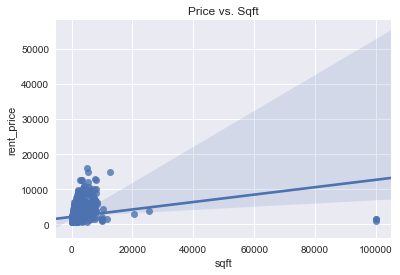

In [68]:
#Plot of Price vs Sqft - looks like most of the data is less than 10k sqft and less than $20k
#However, there are some glaring outliers
plt.title('Price vs. Sqft')
sns.regplot(df1.sqft, df1.rent_price)

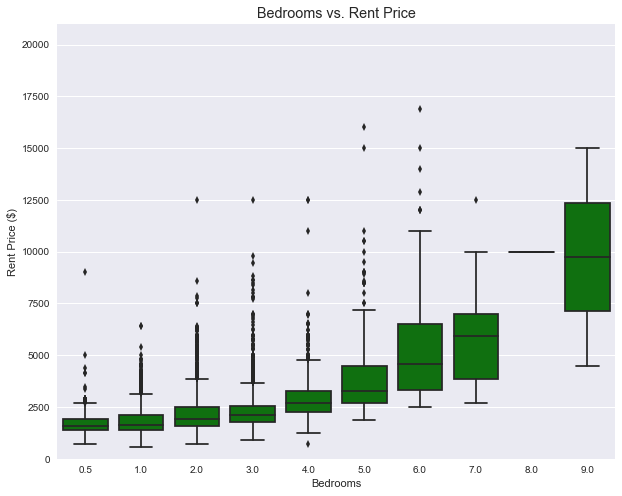

In [69]:
#plot of Price vs Bedrooms
#On average, it looks like the more bedrooms, the higher rent price

f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='bedrooms', y="rent_price", data=df1, color='green')
fig.axis(ymin=0, ymax=21000);
ax.set_title('Bedrooms vs. Rent Price', size='x-large')
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Rent Price ($)')

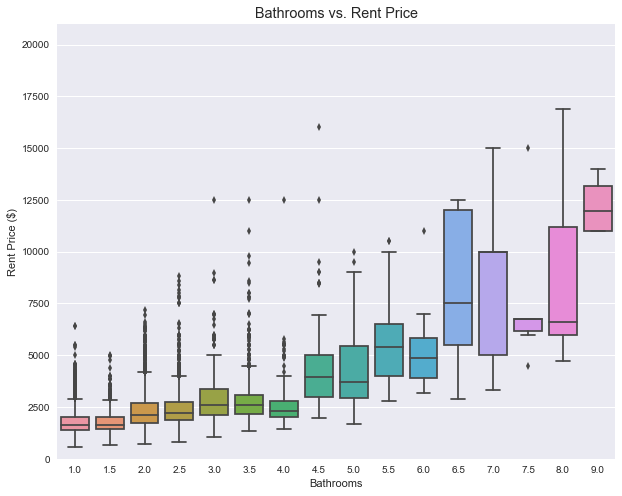

In [70]:
#plot of Price vs Bathrooms - doesn't look as clear cut as bedrooms, but the trend seems
#to be more bathrooms --> higher rent price
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='bathrooms', y="rent_price", data=df1)
fig.axis(ymin=0, ymax=21000);
ax.set_title('Bathrooms vs. Rent Price', size='x-large')
ax.set_xlabel('Bathrooms')
ax.set_ylabel('Rent Price ($)')

From the plots above, we can see that each plot has a positive trend, which makes sense since the more bathrooms, bedrooms, and larger sqft seems to command a higher price. However, we can also notice some outliers, particularly the points with sqft > 20,000, and the 2 bedroom, 1 bathroom rental for $20,000. These points must be explored.

Checking for Outliers

In [71]:
#Checking the rentals for over $20,000
df1[df1['rent_price'] >= 20000]

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,neighborhoods


This listing does not appear to be a realistic observation, with a $20,000 rent price and only 2 bedrooms and one bathroom. We will remove it

In [72]:
df1 = df1.drop(df1[df1['rent_price'] == 20000].index) #Drop the row where rent_price = $20,000

From the table below, we can see that some have sqft of 99999, or high square footage, with unrealistically low rent prices. These points maybe have been inputting incorrectly, so we will drop these points because they will add noise the the data. 

In [73]:

df1[df1.sqft > 10000]

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,neighborhoods
30,https://www.renthop.com/apartments/5327-carswe...,5327 Carswell Avenue,38.8175,-76.8992,2857177,99999.0,930,1.0,1.0,"['Featured', '24 Hour Maintenance', 'Bilingual...",...,0,0,0,0,0,0,0,0,0,Camp Springs
104,https://www.renthop.com/apartments/5327-carswe...,5327 Carswell Avenue,38.8175,-76.8992,2857027,99999.0,1533,3.0,1.0,"['Featured', '24 Hour Maintenance', 'Bilingual...",...,0,0,0,0,0,0,0,0,0,Camp Springs
1770,https://www.renthop.com/apartments/43760-trade...,43760 Trade Center Place,38.9689,-77.4884,13115328,10400.0,4500,1.0,2.0,['dishwasher'],...,0,0,0,0,0,0,0,0,0,Dulles
6893,https://www.renthop.com/apartments/2120-tangle...,2120 Tanglewood Drive,38.6457,-76.9008,11765173,11550.0,1400,3.0,1.5,"['storage', 'cable', 'dishwasher', 'refrigerat...",...,0,0,0,0,0,0,0,0,0,Waldorf
7237,https://www.renthop.com/apartments/1005-white-...,1005 White Chimney Court,38.9684,-77.2602,9989996,12751.0,15000,6.0,7.5,"['elevator', 'dishwasher', 'dryer', 'ac', 'ref...",...,0,0,0,0,0,0,0,0,0,McLean
7456,https://www.renthop.com/apartments/13300-kilma...,13300 Kilmarnock Way,39.1466,-77.2756,13212952,99999.0,1475,2.0,2.0,['ac'],...,0,0,0,0,0,0,0,0,0,Germantown
7926,https://www.renthop.com/apartments/3002-glebe-...,3002 Glebe Road S,38.8449,-77.0664,18490390,20525.0,2995,3.0,3.5,"['Contemporary', 'Dishwasher', 'Dryer', 'Garba...",...,0,0,0,0,0,0,0,0,0,Arlington Ridge
8056,https://www.renthop.com/apartments/7442-carria...,7442 Carriage Hills Drive,38.9256,-77.2007,18422045,25540.0,3800,3.0,5.0,"['Colonial', 'Central A/C', 'Zoned A/C', 'Forc...",...,0,0,0,0,0,0,0,0,0,McLean


In [74]:
rows_to_drop = df1[df1.sqft > 10000].index #drop rows over 10k sqft

In [75]:
#Drop data points with sqft greater than 10000

df1 = df1.drop(rows_to_drop)

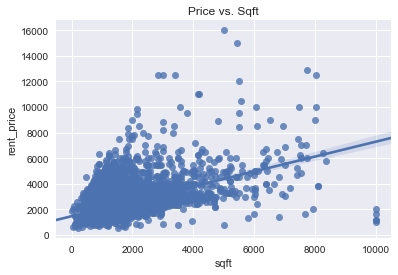

In [76]:
#Plot of Price vs Sqft
plt.title('Price vs. Sqft')
sns.regplot(df1.sqft, df1.rent_price)

After creating another plot I noticed a strange group of points with a rent price of $2000 or less and sqft around 10k. Let's explore these.

In [77]:
#From the table below, we can see the same issue with incorrect sqft data as above. 
#We will also drop these points.
df1[(df1['sqft'] > 9000) & (df1['rent_price'] < 2000)]

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,neighborhoods
1209,https://www.renthop.com/apartments/10379-green...,10379 Green Holly Terrace,39.0254,-77.0403,13213056,9999.0,1995,3.0,3.5,"['dishwasher', 'dryer', 'refrigerator', 'washer']",...,0,0,0,0,0,0,0,0,0,Forest Glen
8816,https://www.renthop.com/apartments/12407-hicko...,12407 Hickory Tree Way,39.1746,-77.2570,18463845,9999.0,1150,2.0,1.0,"['Central A/C', 'Forced Air', 'Exterior Brick']",...,0,0,0,0,0,0,0,0,0,Germantown
9562,https://www.renthop.com/apartments/18334-strea...,18334 Streamside Drive,39.1571,-77.1684,18414798,9999.0,1025,1.0,1.0,"['Dryer', 'Microwave', 'Refrigerator', 'Washer...",...,0,0,0,0,0,0,0,0,0,Gaithersburg
9849,https://www.renthop.com/apartments/12411-hicko...,12411 Hickory Tree Way,39.1746,-77.2569,18603329,9999.0,1195,2.0,2.0,"['Dishwasher', 'Dryer', 'Refrigerator', 'Washe...",...,0,0,0,0,0,0,0,0,0,Germantown
10038,https://www.renthop.com/apartments/1201-east-w...,1201 East West Highway,38.9907,-77.0295,18674983,9999.0,1650,1.0,1.0,"['Dishwasher', 'Dryer', 'Microwave', 'Refriger...",...,0,0,0,0,0,0,0,0,0,Downtown Silver Spring


In [78]:
df1 = df1.drop(df1[(df1['sqft'] > 9000) & (df1['rent_price'] < 2000)].index)

We should also look at the lower values for sqft to make sure there are nonzero values, and to make sure there are no outliers. For the below values, their sqft does not seem plausible and they do not seem to keep up with the trend in the graphs above. Therefore, we will drop these.

In [79]:
df1[df1['sqft'] < 100] #Check for outliers under 100 sqft

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,neighborhoods
2060,https://www.renthop.com/apartments/5730-virgin...,5730 Virginia Lane,38.8124,-76.9680,12982901,32.0,2050,3.0,2.5,"['dishwasher', 'dryer', 'ac', 'refrigerator', ...",...,0,0,0,0,0,0,0,0,0,Oxon Hill
3112,https://www.renthop.com/apartments/157-fleet-s...,157 Fleet Street,38.7838,-77.0155,18606485,90.0,2250,2.0,1.0,"['Cooktop', 'Dishwasher', 'Dryer', 'Garbage Di...",...,0,0,0,0,0,0,0,0,0,Chesapeake Beach
7510,https://www.renthop.com/apartments/6517-creek-...,6517 Creek Run Drive,38.8192,-77.4312,12120407,32.0,600,1.0,1.0,"['internet', 'playground']",...,0,0,0,0,0,0,0,0,0,Centreville
9238,https://www.renthop.com/apartments/2754-sweetw...,2754 Sweetwater Court,38.8491,-76.9175,18428806,1.0,1830,3.0,2.5,"['New Traditional', 'Heat Pumps', 'Exterior Al...",...,0,0,0,0,0,0,0,0,0,District Heights


In [80]:
df1 = df1.drop(df1[df1['sqft'] < 100].index) #Remove outliers under 100 sqft

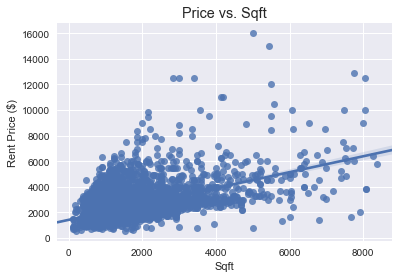

In [81]:
#Plot of Price vs Sqft - see positive relationship between price and sqft
plt.title('Price vs. Sqft', size='x-large')
sns.regplot(df1.sqft, df1.rent_price)
plt.xlabel('Sqft')
plt.ylabel('Rent Price ($)')

In [ ]:
#Geocoding to get neighborhood for each observation from longitude and latitude

hoods = []

G = Geocoder('YOUR_API_CODE_HERE')

for coor in tqdm(range(len(df))):
    add = G.reverse_geocode(df['lats'][coor], df['longs'][coor])
    if add.neighborhood == None:
        hoods.append(add.locality)
    else:
        hoods.append(add.neighborhood)
    time.sleep(0.5)


In [ ]:
df['neighborhoods'] = hoods #add the neighborhoods to df

In [ ]:
dfhoods = df.neighborhoods #create df to save neighborhoods 

In [82]:
#save neighborhoods to an excel file

#from pandas import ExcelWriter
#writer = ExcelWriter('DC_Neighborhoods.xlsx')
#dfhoods.to_excel(writer)
#writer.save()

In [84]:
dummies = pd.get_dummies(df1.neighborhoods) # create dummy variables for each neighborhood

Create a df to build a linear model for imputing missing sqft values I will use the values for bedrooms bathrooms to predict sqft. First, by removing null entries for sqft and using non-missing data entries to fit a linear regression model and predict on the missing data

In [85]:
dfreg = df1[['sqft', 'bedrooms', 'bathrooms']].copy()

In [86]:
dfreg.head()

,sqft,bedrooms,bathrooms
1,1160.0,3.0,2.0
2,515.0,1.0,1.5
3,989.0,3.0,2.5
4,989.0,2.0,1.5
5,916.0,1.0,1.5


In [87]:
#Get all observations with sqft = NaN
null_data = dfreg[dfreg.isnull().any(axis=1)]

In [88]:
null_data.head()

,sqft,bedrooms,bathrooms
13,NaN,1.0,1.0
24,NaN,2.0,1.5
39,NaN,1.0,1.5
51,NaN,3.0,2.5
61,NaN,1.0,1.5


In [89]:
#drops all the NaN values 
reg_data = dfreg.dropna() 

In [90]:
from sklearn.linear_model import LinearRegression
X = reg_data.drop('sqft', axis = 1)
y = reg_data.sqft
lm = LinearRegression()

In [91]:
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
#View the coefficient values

pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,bedrooms,319.055521
1,bathrooms,434.602733


In [93]:
predictions = lm.predict(X) #get predictions for sqft

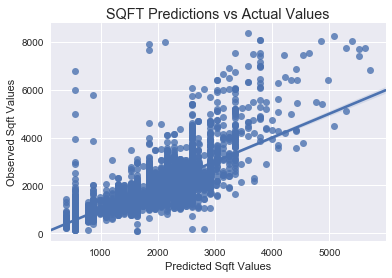

In [94]:
#Plot predictions vs actual values
sns.regplot(predictions, reg_data.sqft)
plt.xlabel('Predicted Sqft Values')
plt.ylabel('Observed Sqft Values')
plt.title('SQFT Predictions vs Actual Values', size='x-large')

In [95]:
#Fit a model to the training data and predict on the test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

print("R^2:", lm.score(X_test, y_test))

R^2: 0.665136256446


In [96]:
#Run cross validation to see how well the model performs

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(lm, X, y, cv=5)

print(cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

[ 0.69405769  0.65482201  0.65086107  0.67109305  0.64874196]
Average 5-Fold CV score: 0.663915155966


In [97]:
X1 = null_data.iloc[:, 1:3]#get all values to impute 
realp = lm.predict(X1) #predicted values from missing data

In [98]:
null_data['sqft'] = realp #add the predicted sqft to null_data df

/Users/TCummings03/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
#fill missing sqft values with predicted values
df1['sqft'] = df1['sqft'].fillna(null_data['sqft']) 

In [100]:
df1.head(3) #check to see if missing data was filled

,listlinks,title_address,lats,longs,ids,sqft,rent_price,bedrooms,bathrooms,amenities,...,West Springfield,Westover,Wheaton,White Plains,Williamsburg,Woodbine,Woodbridge,Woodmont Triangle,Yorktown,neighborhoods
1,https://www.renthop.com/apartments/4905-southl...,4905 Southland Ave,38.8180,-77.1479,2007984,1160.0,1975,3.0,2.0,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,Lincolnia
2,https://www.renthop.com/apartments/9704-clark-...,9704 Clark Pl,38.7434,-77.4669,2059874,515.0,1102,1.0,1.5,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,Manassas
3,https://www.renthop.com/apartments/1002-kenneb...,1002 Kennebec Street,38.8194,-76.9922,3427733,989.0,1529,3.0,2.5,"['Featured', 'Cats Allowed', 'Dogs Allowed', '...",...,0,0,0,0,0,0,0,0,0,Oxon Hill


In [101]:
#Get a baseline case to compare model against:

median_price = df1.rent_price.median()

median_sqft = df1.sqft.median()

median_p_sqft = median_price/median_sqft

baselinep = [median_p_sqft * x for x in df1.sqft]

err = df1.sqft - baselinep

sq_err = err ** 2

mean_sq_err = np.mean(sq_err)

root_mse = np.sqrt(mean_sq_err)

print('Median Rent Price:', df1.rent_price.median())
print('Mean Rent Price:', df1.rent_price.mean())
print('RMSE Base Case:', root_mse)

Median Rent Price: 2100.0
Mean Rent Price: 2365.5429759257468
RMSE Base Case: 1101.4502853


The base case is found by taking the median price/ median sqft and multiplying it by each respective listing's sqft. This "base case" is a fairly crude way of predicting rent price. However, this is useful as a bench mark to see if using a model will actually be useful in trying to predict rent price.  At a minimum, the model should do better than the RMSE from the base case. 

In [102]:
#Create a dataframe with the four columns
dfo = df1.loc[:,['sqft', 'rent_price', 'bedrooms', 'bathrooms']]

In [103]:
#Create the final dataframe that will be used for the model

dfmodel = pd.concat([dfo, dummies, dfamenities], axis=1) 
dfmodel = dfmodel.dropna()

In [104]:
#Create a linear regression model to predict price

from sklearn.linear_model import LinearRegression
X2 = dfmodel.drop(['rent_price'], axis = 1)
y2 = df1['rent_price']
lm = LinearRegression()

lm.fit(X2,y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
lm.score(X2,y2)

0.6878368592649593

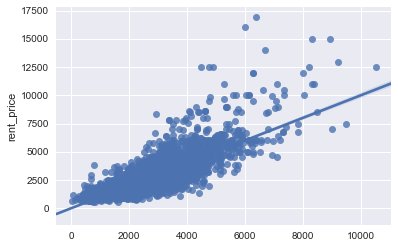

In [106]:
price_pred = lm.predict(X2)
sns.regplot(price_pred, y2)

Root mse 641.661943993
mean rent price: 2365.5429759257468
mean error -9.626181826627912e-08


(array([  6.42218449e-01,   2.25693265e-01,   8.45500849e-02,
          2.89756650e-02,   8.71533673e-03,   3.96151669e-03,
          3.39558574e-03,   9.05489530e-04,   2.26372383e-04,
          4.52744765e-04,   4.52744765e-04,   1.13186191e-04,
          2.26372383e-04,   1.13186191e-04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 <a list of 18 Patch objects>)

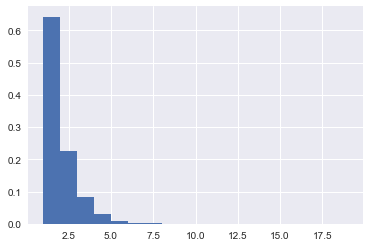

In [107]:
#The error term is observed - predicted values
error = price_pred - y2
squared_error = error ** 2
mse = np.mean(squared_error)
rmse = np.sqrt(mse)
me = np.mean(error)
print('Root mse' , rmse)
print('mean rent price:', np.mean(df1.rent_price))
print('mean error', me)
sqftp = df1.rent_price / df1.sqft
plt.hist(sqftp, bins=np.arange(1,20,1), normed=True)

Fitting a linear model with the data that includes both the 1000+ amenities and 200+ locations proves to be a difficult task for the linear regression model.  With this many features, it may be wise to eliminate some, which may be adding noise to the model. In addition, testing different regression models to see which performs will allow us to pick the best one.  The models we will test are Linear Regression, Random Forest Regression, Elastic Net, and Lasso regression.

In [108]:
features = dfmodel.drop(['rent_price'], axis = 1)
target = df1['rent_price']

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error   #ytrue, ypred

regr = RandomForestRegressor()

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.3, random_state=42)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

print("Test R^2:", regr.score(X_test, y_test))
print("Train R^2:", regr.score(X_train, y_train))

RMSE: 666.258552131
Test R^2: 0.667138121214
Train R^2: 0.942331147087


In [111]:
cv_scores = cross_val_score(regr, features, target, cv=5)

print(cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

[ 0.63170346  0.54022134  0.67856216  0.73939447  0.62832693]
Average 5-Fold CV score: 0.643641674168


In [112]:
from sklearn.linear_model import RidgeCV

features = dfmodel.drop(['rent_price'], axis = 1)
target = dfmodel['rent_price']
RCV = RidgeCV()
RCV.fit(features,target)
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                    test_size = 0.3, random_state=42)
RCV.fit(X_train,y_train)
y_pred = RCV.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R^2:", RCV.score(X_test, y_test))
print("Train R^2:", RCV.score(X_train, y_train))

print('Best Fit Alpha:', RCV.alpha_)

cv_scores = cross_val_score(RCV, features,target, cv=5)

print(cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

RMSE: 690.326467445
Test R^2: 0.642655159219
Train R^2: 0.691427764911
Best Fit Alpha: 1.0
[ 0.65749114  0.50932932  0.69538225  0.69660027  0.64576862]
Average 5-Fold CV score: 0.64091432257


In [113]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.01)
enet.fit(features,target)
X_train, X_test, y_train, y_test = train_test_split(features,target, test_size = 0.3, random_state=42)
enet.fit(X_train,y_train)
y_pred = enet.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R^2:", enet.score(X_test, y_test))
print("Train R^2:", enet.score(X_train, y_train))

cv_scores = cross_val_score(enet, features,target, cv=5)

print(cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

RMSE: 720.649545568
Test R^2: 0.610572424353
Train R^2: 0.639264129319
[ 0.5980773   0.51758599  0.6470196   0.65993461  0.61565392]
Average 5-Fold CV score: 0.607654284476


Model results:

Random Forest Regressor:
Not only is the RMSE of the random forest regressor high (666) the difference between the r^2 of the test and training set are very different. This looks like the random forest regressor has overfit the data.

Ridge Regression:
A RMSE of 738 is not very good considering the median and mean rent price are 2,100 and 2,382 respectively.  In addition to improving upon this, we should also aim to imporve the r^2 of .637.

Elastic Net Regression:

Like ridge regression, Elastic Net has an RMSE in the 700s, 766.  In addition to a higher RMSE, it also has a lower r^2 at .609. 

Let's do some further exploration to see how to improve these metrics, and find out which models performs best

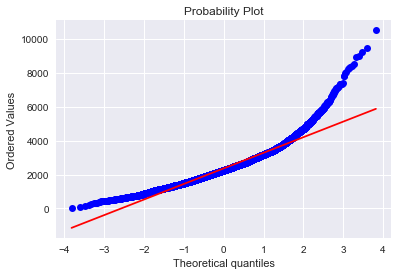

In [114]:
#From the QQ plot below, we can see pretty quickly that there appear 
#to be some extreme values in the data. 

stats.probplot(price_pred, dist="norm", plot=pylab)
pylab.show()

From the graph above, we will try two approaches to improve our models and/or see which one performs the best:
1. Feature Selection:
    a) We will do future selection - removing some features that do not appear in at least 1% of observations
    b) We will remove observations for neighborhoods with less than 15 reported
2. Feature transformation:
Due to the extreme values in the plot above, we will take the log of the continuous variables (rent price, sqft, bedrooms)

In [115]:
dfamenities1 = dfamenities.copy()
dummies1 = dummies.copy()
dfo1 = np.log(dfo.copy())

In [116]:
dfo1.head()

,sqft,rent_price,bedrooms,bathrooms
1,7.056175,7.588324,1.098612,0.693147
2,6.244167,7.004882,0.000000,0.405465
3,6.896694,7.332369,1.098612,0.916291
4,6.896694,7.169350,0.693147,0.405465
5,6.820016,7.283448,0.000000,0.405465


In [117]:
#Drops all amenities columns that appear in less than 0.1% of observations

columns_to_drop = []

for c in dfamenities1.columns:
    
    c_series = dfamenities1[c] 

# check the fraction of the most represented value
    if c_series.value_counts(normalize=True).max() >= 0.999:
        columns_to_drop.append(c)

dfamenities1.drop(columns_to_drop, axis=1, inplace=True)


In [118]:
#Creates the model df

dfmodel1 = pd.concat([dfo1, dummies1, dfamenities1], axis=1)
dfmodel1 = dfmodel1.dropna()

features = dfmodel1.drop(['rent_price'], axis = 1)
target = dfo1['rent_price']


In [119]:
#This drops neighborhoods

less_than_10 = []

for c in dummies1.columns:
    
    c_series = dummies1[c] 

# check to see if value appears less than 15 times
    if np.count_nonzero(c_series) < 15:
        less_than_10.append(c)

dummies1.drop(less_than_10, axis=1, inplace=True)


In [120]:
#Gets indices from each element of less_than_10

indices = []

for hood in less_than_10:
    indices.append(df1.loc[df1[hood] == 1].index)

In [121]:
flat_list = [item for sublist in indices for item in sublist] #delist

In [122]:
dfmodel1 = dfmodel1.drop(flat_list)

In [123]:
#Linear model

#Fit a model to the training data and predict on the test set
#From below, we can see that the model does well on the training data
#but breaks down on the test data 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.3, random_state=42)

lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R^2:", lm.score(X_test, y_test))
print("Train R^2:", lm.score(X_train, y_train))

RMSE: 3215665319.34
Test R^2: -6.75904286682e+19
Train R^2: 0.760224855654


[ 7.996171    6.87922478  7.28110981  7.05756283  7.25714302]
1    7.588324
2    7.004882
3    7.332369
4    7.169350
5    7.283448
Name: rent_price, dtype: float64
Root mse 3215665319.34
mean rent price: 2365.5429759257468
mean error -43995159.012150295
Average price of test set: 7.687537546222118


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 <a list of 18 Patch objects>)

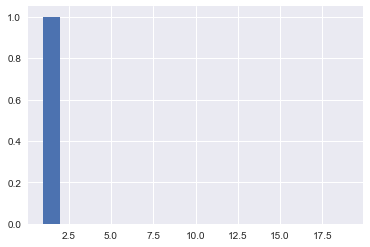

In [124]:
price_pred = lm.predict(features)
error = y_test - y_pred
squared_error = error ** 2
mse = np.mean(squared_error)
rmse = np.sqrt(mse)
me = np.mean(error)
print(price_pred[:5])
print(target[:5])
#print('error:', error)
print('Root mse' , rmse)
print('mean rent price:', np.mean(df1.rent_price))
print('mean error', me)
print('Average price of test set:', np.mean(y_test))
sqftp = dfo1.rent_price / dfo1.sqft
plt.hist(sqftp, bins=np.arange(1,20,1), normed=True)

In [125]:
from sklearn.linear_model import RidgeCV

features = dfmodel1.drop(['rent_price'], axis = 1)
target = dfmodel1['rent_price']
RCV = RidgeCV(alphas=[1.0])
RCV.fit(features,target)
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                    test_size = 0.3, random_state=42)
RCV.fit(X_train,y_train)
y_pred = RCV.predict(X_test)

print('Mean log price', target.mean())
print('Median log price', target.median())
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R^2:", RCV.score(X_test, y_test))
print("Train R^2:", RCV.score(X_train, y_train))

print(RCV.alpha_)

cv_scores = cross_val_score(RCV, features,target, cv=5)

print('CV Scores:', cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

Mean log price 7.684879565112164
Median log price 7.649692623711514
RMSE: 0.203606334124
Test R^2: 0.732756273503
Train R^2: 0.756220570193
1.0
CV Scores: [ 0.70811625  0.53402195  0.77400852  0.7776713   0.75765026]
Average 5-Fold CV score: 0.710293657523


In [126]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(l1_ratio=0.01)
enet.fit(features,target)
X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                    test_size = 0.3, random_state=42)
enet.fit(X_train,y_train)
y_pred = enet.predict(X_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R^2:", enet.score(X_test, y_test))
print("Train R^2:", enet.score(X_train, y_train))

cv_scores = cross_val_score(enet, features,target, cv=5)

print(cv_scores)
print("Average 5-Fold CV score:", np.mean(cv_scores))

RMSE: 0.351245158278
Test R^2: 0.204673153144
Train R^2: 0.204480013547
[ 0.16800549  0.20771378  0.21644136  0.19896913  0.19969165]
Average 5-Fold CV score: 0.198164282817


In [134]:
# The coefficients
cofs = pd.DataFrame({'features': features.columns, 'estimatedCoefficients': RCV.coef_})[['features', 'estimatedCoefficients']]

In [148]:
#Top10
cofs.sort_values(by='estimatedCoefficients', ascending=False).iloc[:10,:]

,features,estimatedCoefficients
76,Downtown,0.488699
169,Northwest Washington,0.436177
144,Lyon Village,0.433512
166,North Rosslyn,0.399506
64,Court House,0.395800
20,Aurora Highlands,0.379157
230,Tysons,0.371944
175,Old Town,0.320081
177,Old Town West,0.311624
53,Chevy Chase,0.311621


In [149]:
#Bottom10
cofs.sort_values(by='estimatedCoefficients', ascending=True).iloc[:10,:]

,features,estimatedCoefficients
96,Fredericksburg,-0.396204
219,Stafford,-0.343588
79,Dumfries,-0.295470
195,Prince Frederick,-0.293312
153,Montclair,-0.279973
97,Gainesville,-0.269134
229,Triangle,-0.255075
146,Manassas,-0.254669
122,Indian Head,-0.245377
249,Woodbridge,-0.243756


As we can see from above, the linear model and elastic net model do not perform as well as the RidgeCV model , with 1.0 alpha. Our metric here is the RMSE which is as follows:

Final Scores:
--

RMSE Linear Regression: (3215665319.34)

RMSE RidgeCV: 0.203606334124

RMSE ElasticNet: 0.351245158278

Because of the above scores, we can determine that the best model for predicting rental prices in DC, with the given set of features, is the RidgeCV model.  Furthermore, it is interesting to note that if we were to go by r^2 values, then the ElasticNet model would actually perform better. However, our for our particular clients, renters and businesses, price accuracy is probably the most important output of a model.  Renters need to know how much they should be paying for rent so they do not overpay, and businesses need to make sure they are not undercharging their renters and leaving money on the table.  